In [6]:
from pdf_reader import PDFReader
from preprocessor import Preprocessor
from vectorizer import Vectorizer
from feature_extractor import Extractor
from rf_model import RFModel
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import os

In [2]:
# Load Word2Vec model
vectorizer = Vectorizer("word2Vec_models/cbow_s1000.txt")

In [3]:
pdf_reader = PDFReader()
preprocessor = Preprocessor()
feature_extractor = Extractor(vectorizer, pdf_reader, preprocessor)

# Create BoW representation of documents
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2)

rf_clf = RFModel()

In [4]:
# Process training data
train_doc_names = [filename for filename in os.listdir('train/') if filename.endswith('.pdf')]
file_paths_train = [os.path.join('train', filename) for filename in train_doc_names]
X_combined = feature_extractor.extract_features(file_paths_train)

# Define labels for the documents
y = []
for filename in train_doc_names:
  if filename.startswith("risk"):
    label = 0  # Risk Report
  elif filename.startswith("politicaSegurancaInformacao"):
    label = 1  # Privacy Policy
  y.append(label)

# Hyperparameter Tuning
param_grid = {
  'n_estimators': [100, 200, 300],
  'max_features': ['sqrt', 'log2'],
}
print(f"\nBest Parameters: {rf_clf.tune_hyperparameters(X_combined, y, param_grid)}\n")

# Training the model
rf_clf.fit(X_combined, y)

# Evaluating the model
print(f"Model Evaluation Metrics: \n{rf_clf.evaluate_model(X_combined, y, cv=5)}")


Best Parameters: {'max_features': 'sqrt', 'n_estimators': 100}

Model Evaluation Metrics: 
{'Confusion Matrix': array([[14,  0],
       [ 0, 16]]), 'ROC AUC': 1.0, 'Precision-Recall AUC': 1.0, 'Accuracy': 1.0, 'Cross-Validation Average Score': 0.9333333333333333}


Test Data Evaluation Metrics: 
{'Confusion Matrix': array([[4, 0],
       [0, 2]]), 'ROC AUC': 1.0, 'Precision-Recall AUC': 1.0, 'Accuracy': 1.0}

politicaSegurancaInformacao18.pdf: True Label = 1, Predicted Label = 1
risk.pdf: True Label = 0, Predicted Label = 0
risk4.pdf: True Label = 0, Predicted Label = 0
politicaSegurancaInformacao17.pdf: True Label = 1, Predicted Label = 1
risk3.pdf: True Label = 0, Predicted Label = 0
risk2.pdf: True Label = 0, Predicted Label = 0


<Figure size 1000x600 with 0 Axes>

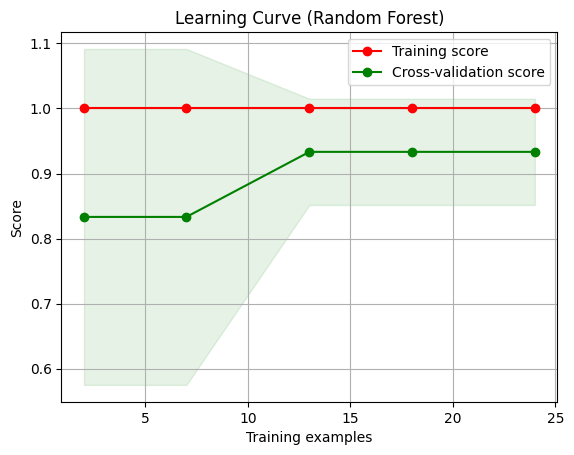

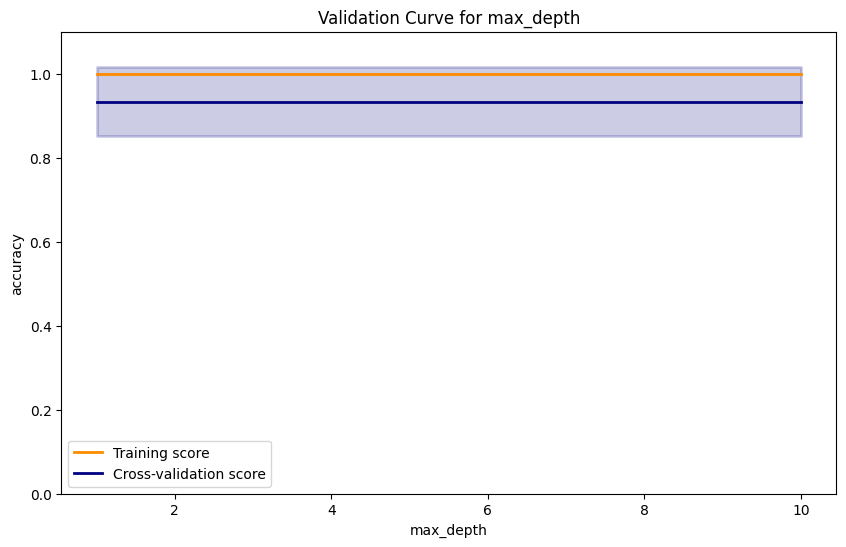

In [7]:
# Analyze new data
analyze_doc_names = [filename for filename in os.listdir('test/') if filename.endswith('.pdf')]
file_paths_new = [os.path.join('test', filename) for filename in analyze_doc_names]
new_X_combined = feature_extractor.extract_features(file_paths_new)

# Define labels for the test documents
true_labels_test = []
for filename in analyze_doc_names:
  if filename.startswith("risk"):
    label = 0  # Risk Report
  elif filename.startswith("politicaSegurancaInformacao"):
    label = 1  # Privacy Policy
  true_labels_test.append(label)

# Predicting labels for new data using Random Forest
predictions = rf_clf.predict(new_X_combined)

# Evaluate the model on new data
metrics_test = rf_clf.evaluate_model(new_X_combined, true_labels_test, cv=None)
print(f"Test Data Evaluation Metrics: \n{metrics_test}\n")

# Compare predicted labels with true labels for an overview
for doc, true_label, predicted_label in zip(analyze_doc_names, true_labels_test, predictions):
  print(f"{doc}: True Label = {true_label}, Predicted Label = {predicted_label}")

# Plot learning curve
RFModel.plot_learning_curve(rf_clf.clf, "Learning Curve (Random Forest)", X_combined, y, cv=5, n_jobs=4)

# Plot validation curve
RFModel.plot_validation_curve(rf_clf.clf, X_combined, y, param_name="max_depth", param_range=np.arange(1, 11), cv=5)